# Typical Time History for Steam Demand at UIUC

Please see the ``README`` for instructions about accessing the data (UIUC Steam Data is currently not cleared for publication).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
plt.rcParams['figure.figsize'] = (12,9)

## Upload data

In [2]:
# define path to data
path = "../../data/" 

In [3]:
# upload datasets
steam15 = pd.read_csv(path+'steamfy15.csv', parse_dates=True, index_col=['Date and Time'])
steam16 = pd.read_csv(path+'steamfy16.csv', parse_dates=True, index_col=['Date and Time'])
steam17 = pd.read_csv(path+'steamfy17.csv', parse_dates=True, index_col=['Date and Time'])
steam18 = pd.read_csv(path+'steamfy18.csv', parse_dates=True, index_col=['Date and Time'])
steam19 = pd.read_csv(path+'steamfy19.csv', parse_dates=True, index_col=['Date and Time'])

## Combine the datasets

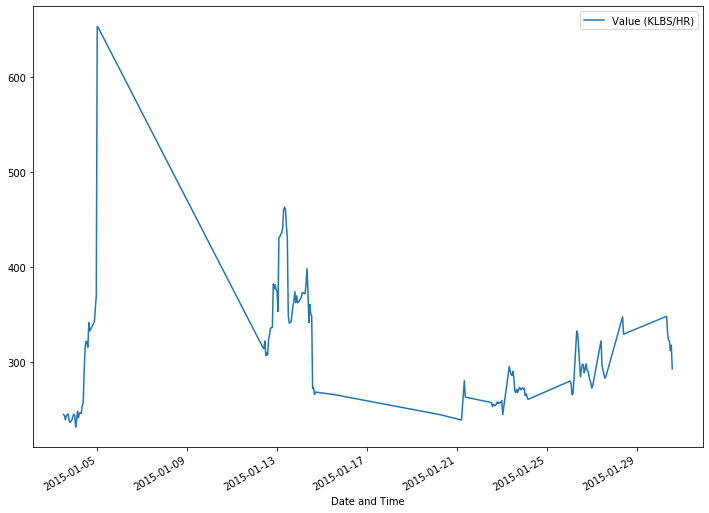

In [4]:
steam15[(steam15['eDNA Status as String'] == 'UNRELIABLE') & (steam15.index.month <= 1)].plot()

In [5]:
frames = [steam15, steam16, steam17, steam18, steam19]

all_data = pd.concat(frames)

# all_data

In [6]:
all_data.head()

,Value (KLBS/HR),eDNA Status as String
Date and Time,,
2014-07-01 00:00:00,105.872467,UNRELIABLE
2014-07-01 01:00:00,104.659416,UNRELIABLE
2014-07-01 02:00:00,105.016411,UNRELIABLE
2014-07-01 03:00:00,106.378754,UNRELIABLE
2014-07-01 04:00:00,106.899544,UNRELIABLE


There is some data marked as 'UNRELIABLE' by eDNA, but it looks mostly okay, except for a couple of days in 2015 that show 0 demand in the winter. We can fix that by interpolating. It looks like the worst data is confined to 2014, which we don't want to use anyway because we can only use complete years of data. 

## Separate the data into complete years

In [7]:
all_data.drop(['eDNA Status as String'], axis=1, inplace=True)

In [8]:
all_data.rename(columns = {'Value (KLBS/HR)':'demand'}, inplace=True)

all_data.head()

,demand
Date and Time,
2014-07-01 00:00:00,105.872467
2014-07-01 01:00:00,104.659416
2014-07-01 02:00:00,105.016411
2014-07-01 03:00:00,106.378754
2014-07-01 04:00:00,106.899544


### Generate Synthetic Histories

After the synthetic histories (which give flow rates) have been generated, we can calculate the MWth demand.

It makes more sense to convert to thermal demand before generating the synthetic histories. Why do something more than once if you don't have to?

We use the equation

$P_{th} = \dot{Q} = \dot{m}c_p\Delta T$. 

This equation gives the thermal power required to heat a certain amount of water to a certain temperature. 

At 120$^\circ$C the $c_p$ of water is 4243.5 [J/kg K]

$\Delta T$ is 179$^\circ$C

Alternatively, we can use the change in enthalpy to calculate the power requirement. According to the master plan the inlet enthalpy is 196 BTU/lb and the outlet enthalpy after superheating is 1368 BTU/lb. 

We can convert to $P_{th}$ by 

$P_{th} = \dot{m}\Delta h$

Using the typical history of steam mass flow rates.m

In [9]:
# define conversion function
cp = 4243.5 # J/kg K
dT = 179 # deg C

h_in = 196 # BTU/lb
h_out = 1368 # BTU/lb

# times 0.29307107 to convert from BTU/hr to kilowatts
to_kwth = lambda mdot: (mdot*(h_out-h_in))*0.29307107

In [10]:
to_kwth(800)/1e3*0.33

90.67853362656003

In [11]:
all_data['kw'] = all_data['demand'].apply(to_kwth)
all_data

,demand,kw
Date and Time,,
2014-07-01 00:00:00,105.872467,36365.000223
2014-07-01 01:00:00,104.659416,35948.342391
2014-07-01 02:00:00,105.016411,36070.962644
2014-07-01 03:00:00,106.378754,36538.899222
2014-07-01 04:00:00,106.899544,36717.779838
...,...,...
2019-06-30 19:00:00,117.837962,40474.899999
2019-06-30 20:00:00,116.572045,40040.083721
2019-06-30 21:00:00,114.853680,39449.860924


In [12]:
years = all_data.groupby(all_data.index.year)

In [13]:
steam_data15 = years.get_group(2015)
steam_data16 = years.get_group(2016)
steam_data17 = years.get_group(2017)
steam_data18 = years.get_group(2018)

## Preparing the datasets to be used in RAVEN

This data will be read by RAVEN as HistorySets (a datatype of RAVEN) and will have two columns 

time | demand

where ``time`` is in hours and ``demand`` is in klbs/hr and ``kw`` is in kW thermal

In [14]:
%%capture
steam_data15.reset_index(inplace=True)
steam_data15['time'] = steam_data15.index
steam_data15.drop(['Date and Time','demand'], axis=1, inplace=True)
steam_data15.head()

In [15]:
steam_data15

,kw,time
0,110024.747013,0
1,112596.753663,1
2,113884.255948,2
3,111746.346812,3
4,111590.015955,4
...,...,...
8755,111513.684895,8755
8756,103501.606851,8756
8757,106569.524337,8757
8758,104145.661990,8758


In [16]:
sum15 = steam_data15.kw.sum()/1e3 # MWh
print(f"The total steam demand for 2015 was {round(sum15, 2)} MWh")

The total steam demand for 2015 was 564516.22 MWh


In [17]:
%%capture
steam_data16.reset_index(inplace=True)
steam_data16['time'] = steam_data16.index
steam_data16.drop(['Date and Time','demand'], axis=1, inplace=True)
steam_data16 = steam_data16[:8760]
steam_data16.head()

In [18]:
%%capture
steam_data17.reset_index(inplace=True)
steam_data17['time'] = steam_data17.index
steam_data17.drop(['Date and Time','demand'], axis=1, inplace=True)
steam_data17.head()

In [19]:
%%capture
steam_data18.reset_index(inplace=True)
steam_data18['time'] = steam_data18.index
steam_data18.drop(['Date and Time','demand'], axis=1, inplace=True)
steam_data18.head()

## Download the RAVEN datasets

In [20]:
# writes the header file for RAVEN
fname = 'annual_steam201'
keys = [fname + str(i) + '.csv' for i in range(5,9,1)]
header_file = pd.DataFrame({'scaling':np.zeros(len(keys), dtype=np.int8), 'filename':keys})
header_file.to_csv(path+'annual_steam_H.csv')
print(keys)

['annual_steam2015.csv', 'annual_steam2016.csv', 'annual_steam2017.csv', 'annual_steam2018.csv']


In [21]:
steam_data15.to_csv(path+'annual_steam2015.csv')
steam_data16.to_csv(path+'annual_steam2016.csv')
steam_data17.to_csv(path+'annual_steam2017.csv')
steam_data18.to_csv(path+'annual_steam2018.csv')

In [22]:
%%capture
if platform.system() == 'Windows':
    !git-bash %userprofile%/research/raven/raven_framework %userprofile%/research/pride/inputfiles/typical_steam.xml
else:
    !~/research/raven/raven_framework ~/research/pride/inputfiles/typical_steam.xml

In [23]:
typical_steam = pd.read_csv(path+"TypicalSteam_0.csv")

typical_steam['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]

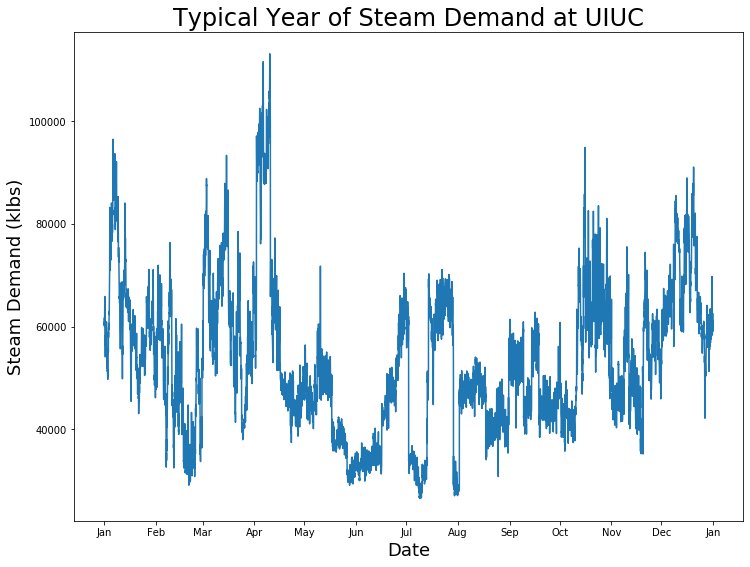

In [24]:
import matplotlib.dates as mdates


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(typical_steam.date, typical_steam.kw)
plt.title('Typical Year of Steam Demand at UIUC', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Steam Demand (klbs)',fontsize=18)

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

In [25]:
typical_steam.kw.mean()

53277.08268612407

In [26]:
# %%capture
if platform.system() == 'Windows':
    !git-bash %userprofile%/research/raven/raven_framework %userprofile%/research/pride/inputfiles/steam_arma.xml
else:
    !~/research/raven/raven_framework ~/research/pride/inputfiles/steam_arma.xml

In [27]:
path = '../../data/'
synthetic_history = pd.read_csv(path+"steamHistories_2.csv")

Text(0.5, 1.0, 'Synthetic and Typical Steam Demand Histories')

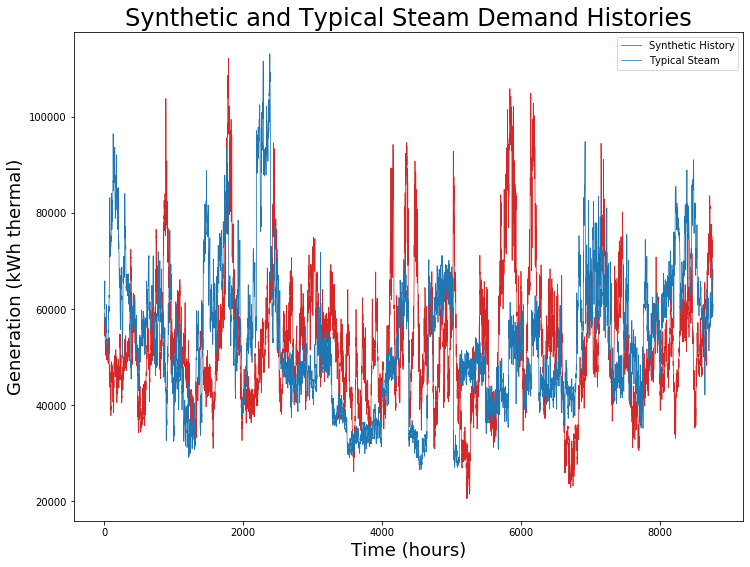

In [28]:
# plot synthetic history
fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(synthetic_history['time'], synthetic_history['kw'], 
         color='tab:red',lw = 0.75, label='Synthetic History')
plt.plot(typical_steam['time'], typical_steam['kw'], 
         color='tab:blue', lw=0.75, label='Typical Steam')
plt.ylabel("Generation (kWh thermal)", fontsize=18)
plt.xlabel("Time (hours)", fontsize=18)
plt.legend()
plt.title("Synthetic and Typical Steam Demand Histories", fontsize=24)
# plt.savefig("../figures/syn_vs_typ_steam.png")

In [29]:
typical_steam.kw.sum()*1e-6*0.33

154.0133906290472

Check the seasonal and daily variations in steam demand, as I did for electric demand.

In [30]:
df15 = steam_data15

In [31]:
inter = ((df15.time >= 1872) & (df15.time < 4104)) | ((df15.time >= 6360) & (df15.time < 8496))
summer = (df15.time >= 4104) & (df15.time < 6360)
winter = (df15.time >= 8496) | (df15.time < 1872)

winter15 = df15.loc[winter]
summer15 = df15.loc[summer]
inter15 = df15.loc[inter]

total_demand = df15.kw.sum() # in kWh_e
sum15_demand = summer15.kw.sum()
win15_demand = winter15.kw.sum()
int15_demand = inter15.kw.sum()

print(f"Demand fractions: {sum15_demand/total_demand} in the summer",
    f"{win15_demand/total_demand} in the winter",
    f"{int15_demand/total_demand} at other times.")

Demand fractions: 0.18430549145182132 in the summer 0.37826468437459 in the winter 0.43742982417358883 at other times.


In [32]:
winter_days = winter15.groupby(np.arange(len(winter15))//24)

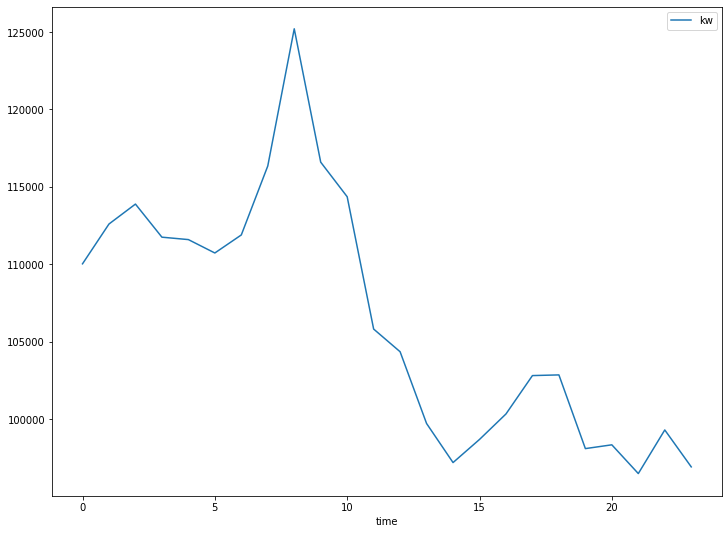

In [33]:
day1 = winter_days.get_group(0)
day1.plot(x='time', y='kw')

In [34]:
daytime = day1.loc[(day1.time > 6) & (day1.time <= 18)].kw.sum()
nighttime = day1.loc[(day1.time <=6) | (day1.time > 18)].kw.sum()
total = day1.kw.sum()

print(f"day is {round(daytime/total,3)} and night is {round(nighttime/total,3)}")

day is 0.502 and night is 0.498


In [35]:
print("Inter demand ",round(0.437*0.502,3))
print("Inter demand ",round(0.437*0.498,3))
print("Winter demand", round(0.378*0.502,3))
print("Winter demand", round(0.378*0.498,3))
print("Summer demand",round(0.184*0.502,3))
print("Summer demand",round(0.184*0.498,3))

Inter demand  0.219
Inter demand  0.218
Winter demand 0.19
Winter demand 0.188
Summer demand 0.092
Summer demand 0.092


In [36]:
0.219+0.218+0.19+0.189+0.092*2

1.0

In [37]:
0.25+0.24+0.112+0.108+0.148+0.142

1.0